In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import itertools
from matplotlib import pyplot as plt
from copy import deepcopy
import random
from sahi import AutoDetectionModel
from sahi.predict import get_prediction
from sahi.predict import get_sliced_prediction
from tqdm import tqdm
from deep_sort_realtime.deepsort_tracker import DeepSort
from pathlib import Path

from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches

import plotly.graph_objects as go
import plotly.express as px
from src.mapping_functions import *

In [2]:
IMAGE_PATH = "data/Wildtrack/image_subsets"
num_images = 10
image_df = load_wildtrack_images(IMAGE_PATH, num_images=num_images)

100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


In [3]:
# Usage:
cam = 'C4'
anim = create_camera_animation(image_df[cam].tolist(), save_path=f'camera_animation_{cam}.mp4', fps=5)

# For inline viewing in Jupyter:
from IPython.display import HTML
HTML(anim.to_html5_video())

Animation saved to saved_files/camera_animation_C4.mp4


In [4]:
model_path = "yolo-models/yolo11n.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cpu"
)

In [5]:
def predict(
    image,
    detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
):
    """
    Returns in xyxy format.
    """
    objects = get_sliced_prediction(
        image=image,
        detection_model=detection_model,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=overlap_height_ratio,
        overlap_width_ratio=overlap_width_ratio,
    ).object_prediction_list

    bboxes = [o.bbox.to_xyxy() for o in objects]
    scores = [o.score.value for o in objects]
    cat = [o.category.name for o in objects]

    return bboxes, scores, cat

In [6]:
IMAGE_INDEX = 1

####
full_data = dict()
for cam in CAMERA_NAMES:
    bboxes, scores, cat = predict(image_df[cam][IMAGE_INDEX], detection_model)
    full_data[cam] = {
        'bboxes': bboxes,
        'scores': scores,
        'categories': cat
    }

Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.
Performing prediction on 15 slices.


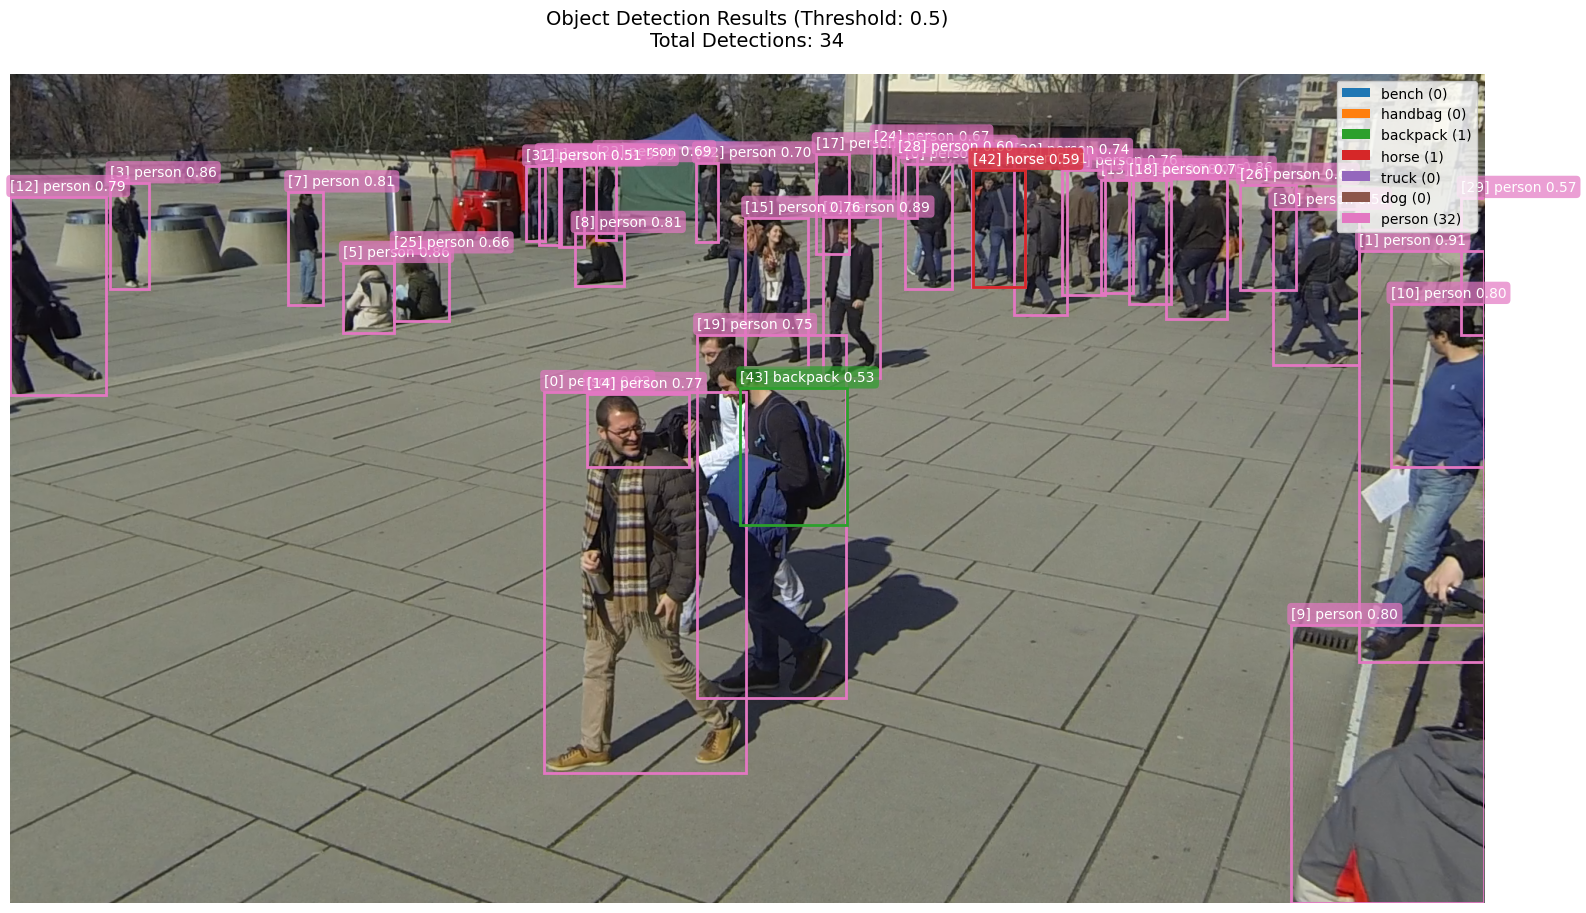


Detection Summary
Total detections: 48
Detections above threshold (0.5): 34

Category breakdown:
  bench: 0 (avg score: nan)
  handbag: 0 (avg score: nan)
  backpack: 1 (avg score: 0.531)
  horse: 1 (avg score: 0.593)
  truck: 0 (avg score: nan)
  dog: 0 (avg score: nan)
  person: 32 (avg score: 0.747)



/Users/eriwang/Desktop/cv-project-2025/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eriwang/Desktop/cv-project-2025/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
cam = "C1"
visualize_predictions(
    image=image_df[cam][IMAGE_INDEX],
    bboxes=full_data[cam]['bboxes'],
    scores=full_data[cam]['scores'],
    categories=full_data[cam]['categories'],
    score_threshold=0.5
)

In [8]:
center_data = dict() # format: {camera_name: camera_center}
ray_slice_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [ray1, ray2, ...]} initialize with empty list
ray_slice_area_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
)
category_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [cat1, cat2, ...]} initialize with empty list
score_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [score1, score2, ...]} initialize with empty list



for name in tqdm(CAMERA_NAMES):
    data = full_data[name]
    for b, score, cat in zip(data['bboxes'], data['scores'], data['categories']):

        points = np.array(
            [
                [b[0], b[1]],
                [b[2], b[1]],
                [b[2], b[3]],
                [b[0], b[3]],
            ]
        )
    

        C, rays = image_points_to_rays(points, name)
        area = quad_area(rays)

        ## Store data 
        center_data[name] = C
        ray_slice_data[name].append(rays)
        ray_slice_area_data[name].append(area)
        category_data[name].append(cat)
        score_data[name].append(score)



100%|██████████| 7/7 [00:00<00:00, 480.11it/s]


In [9]:
# plot rays in 3D, with camera center
ray_length = 2000 # length of the rays for visualization
num_slices = 5

fig = go.Figure()
for name in CAMERA_NAMES:
    C = center_data[name]
    slices = ray_slice_data[name]
    slice_scores = score_data[name]

    # Plot camera center and rotation vector
    add_camera_visuals(
        fig, 
        C, 
        name, 
        extrinsics,
    )

    # Plot rays
    _, sorted_slices = zip(*sorted(zip(slice_scores, slices), key=lambda x: x[0], reverse=True))
    for idx, s in enumerate(sorted_slices):
        if idx > num_slices:
            break
        
        # color by slice index
        c = f"rgb(\
            {random.randint(0, 255)},\
            {random.randint(0, 255)},\
            {random.randint(0, 255)})"

        for ray in s:
            ray_end = C + ray * ray_length
            fig.add_trace(
                go.Scatter3d(
                    x=[C[0], ray_end[0]],
                    y=[C[1], ray_end[1]],
                    z=[C[2], ray_end[2]],
                    mode='lines',
                    line=dict(color=c, width=2),
                    showlegend=False
                )
            )
        

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    title='3D Camera Rays Visualization'
)
fig.show()
    

In [10]:
## Variables
category_to_track = 'person'
xrange = (-500, 1500)
yrange = (-1200, 2500)
zrange = (0, 400)
spacing = 50


################################################################################
# USAGE
################################################################################
# - CAMERA_NAMES: list of camera names (e.g., ['CVLab1', 'CVLab2', ...])
# - intrinsics: dict with camera intrinsic parameters
# - extrinsics: dict with camera extrinsic parameters (rvec, tvec)
# - convert_camera_name_to_filename: function to convert cam names to filename keys
# - ray_slice_data: dict with ray slices per camera
# - ray_slice_area_data: dict with slice areas per camera  
# - category_data: dict with categories per camera
# - score_data: dict with scores per camera

# Step 1: Generate voxel grid
voxel_points_array = generate_voxel_grid(xrange, yrange, zrange, spacing)

# Step 2: Extract camera positions from extrinsics
# This handles your format with rvec/tvec and uses cv2.Rodrigues
camera_positions = get_camera_positions(extrinsics, CAMERA_NAMES, convert_camera_name_to_filename)

# Step 3: Process all cameras in parallel
voxel_dict, valid_indices = process_all_cameras_parallel(
    voxel_points=voxel_points_array,
    CAMERA_NAMES=CAMERA_NAMES,
    camera_positions=camera_positions,
    ray_slice_data=ray_slice_data,
    ray_slice_area_data=ray_slice_area_data,
    category_data=category_data,
    score_data=score_data,
    category_to_track=category_to_track,
    max_workers=4  # Adjust based on your CPU cores
)

# Step 4 (Optional): Convert to original format with point tuples as keys
voxel_dict_with_points = convert_to_point_dict(voxel_dict, voxel_points_array, CAMERA_NAMES)

# Step 5 (Optional): Get list of valid point tuples
valid_points = [tuple(voxel_points_array[idx]) for idx in valid_indices]

Processing 7 cameras with 4 threads...
Total voxels: 23680


Processing cameras: 100%|██████████| 7/7 [00:00<00:00, 42.04it/s]

Kept 11661/23680 voxels with detections


In [11]:
voxel_bbox_associations = dict(zip(
    voxel_dict_with_points.keys(), 
    [ 
        deepcopy(dict(zip( CAMERA_NAMES, [ None for _ in CAMERA_NAMES] ))) for _ in voxel_dict 
    ]
))

voxel_bbox_scores = dict(zip(
    voxel_dict_with_points.keys(), 
    [ 
        0.0 for _ in voxel_dict 
    ]
))

for point in tqdm(voxel_dict_with_points):
    point_info = voxel_dict_with_points[point]

    for cam in CAMERA_NAMES:
        if len(point_info[cam]['slice_idx']) == 0:
            continue

        weights = np.array(point_info[cam]["slice_weight"])
        idxs = np.array(point_info[cam]["slice_idx"])

        best_idx = idxs[np.argmax(weights)]  # find highest weight

        # update match
        voxel_bbox_associations[point][cam] = best_idx

        # update scores
        voxel_bbox_scores[point] += np.max(weights)


100%|██████████| 11661/11661 [00:00<00:00, 153704.77it/s]


In [12]:
# Perform NMS
filtered_scores, filtered_associations = perform_nms(
    voxel_bbox_scores, voxel_bbox_associations
)

print(f"Original voxels: {len(voxel_bbox_scores)}")
print(f"After Suppression: {len(filtered_scores)}")

Original voxels: 11661
After Suppression: 3120


In [13]:
# --- Parameters ---
minimum_matches_for_visual = 5
data_dict = voxel_bbox_associations

# --- Create deterministic colors for each bbox pattern ---
def generate_color(key_tuple):
    random.seed(hash(key_tuple) % 2**32)
    return f"rgb({random.randint(50,255)}, {random.randint(50,255)}, {random.randint(50,255)})"

pattern_to_color = {}

# --- Build scatter data ---
xs, ys, zs = [], [], []
colors = []

for (x, y, z), cams in data_dict.items():
    if sum(v is not None for v in cams.values()) < minimum_matches_for_visual:
        continue

    xs.append(x)
    ys.append(y)
    zs.append(z)

    # Turn cam-bbox dict into a tuple signature
    key = tuple(cams.values())

    # If this pattern hasn't been assigned a color yet, add one
    if key not in pattern_to_color:
        pattern_to_color[key] = generate_color(key)

    colors.append(pattern_to_color[key])

# --- Plotly scatter ---
fig = go.Figure(
    data=go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode='markers',
        marker=dict(size=4, color=colors, opacity=0.85)
    )
)
# Plot camera centers for reference
for name in CAMERA_NAMES:
    C = center_data[name]
    
    # Plot camera center and rotation vector
    add_camera_visuals(
        fig, 
        C, 
        name, 
        extrinsics,
    )

fig.update_layout(
    scene=dict(aspectmode='data'),
    title="3D Voxel Bounding-Box Pattern Visualization",
    height=900,
    width=1200,  
)

fig.show()


100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


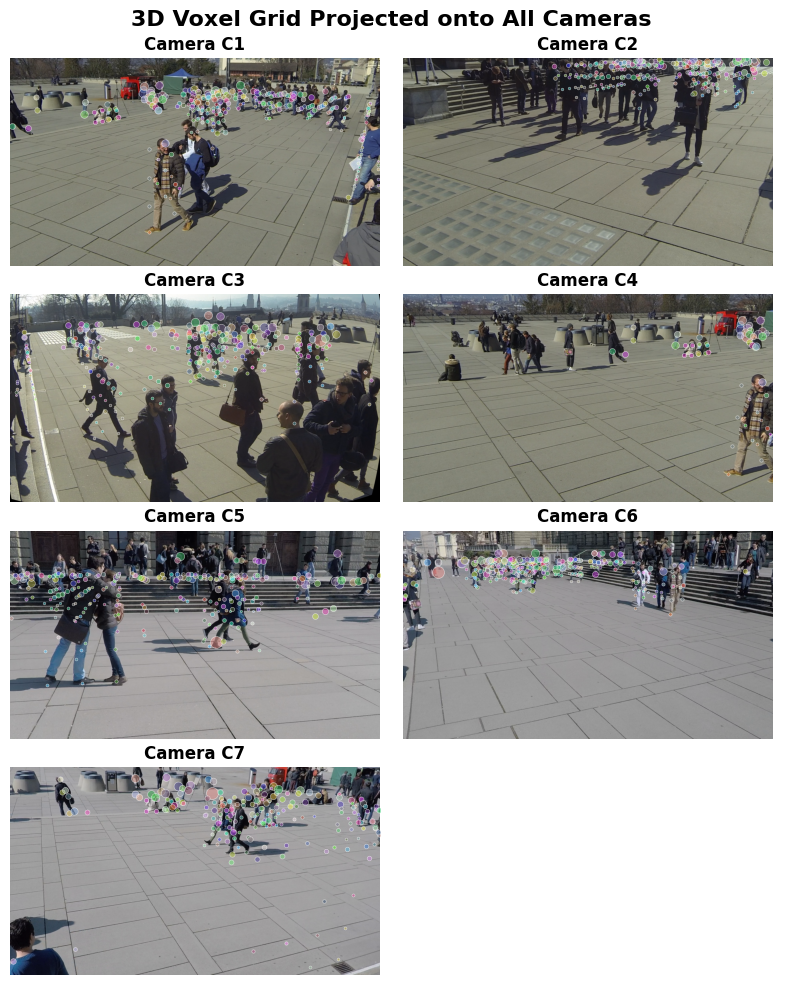

In [22]:
# --- Parameters ---
size_scale = 500 / max(list(voxel_bbox_scores.values())) # Scale for marker sizes
opacity = 0.5
minimum_matches_for_visual = 5
data_dict = voxel_bbox_associations
score_dict = voxel_bbox_scores

# --- Step 1: Extract voxel positions and intensities ---
def generate_color_tuple(key_tuple):
    random.seed(hash(key_tuple) % 2**32)
    return (
        random.randint(50, 255) / 255,
        random.randint(50, 255) / 255,
        random.randint(50, 255) / 255,
    )

# Pre-process data once for all cameras
pattern_to_color = {}
point_positions = []
colors = []
sizes = []

for point, cams in data_dict.items():
    num_matches = sum(v is not None for v in cams.values())
    if num_matches < minimum_matches_for_visual:
        continue
    
    sizes.append(score_dict[point] * size_scale) # scores
    point_positions.append(point)
    
    # Turn cam-bbox dict into a tuple signature
    key = tuple(cams.values())
    
    # If this pattern hasn't been assigned a color yet, add one
    if key not in pattern_to_color:
        pattern_to_color[key] = generate_color_tuple(key)
    
    colors.append(pattern_to_color[key])

# --- Step 2: Create subplots for all cameras ---
fig, axes = plt.subplots(4, 2, figsize=(8, 10))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

for cam_idx, camera in enumerate(tqdm(CAMERA_NAMES)):
    ax = axes[cam_idx]
    
    # Project points to this camera
    image_positions = world_points_to_image_points(
        point_positions,
        camera
    )
    
    # Get the image for this camera
    image_overlay = image_df[camera][IMAGE_INDEX].copy()
    
    # Filter out points outside the image boundaries
    height, width = image_overlay.shape[:2]
    valid_mask = (
        (image_positions[:, 0] >= 0) & 
        (image_positions[:, 0] < width) &
        (image_positions[:, 1] >= 0) & 
        (image_positions[:, 1] < height)
    )
    
    # Apply the mask to get valid positions, colors, and sizes
    valid_positions = image_positions[valid_mask]
    valid_colors = [colors[i] for i in range(len(colors)) if valid_mask[i]]
    valid_sizes = [sizes[i] for i in range(len(sizes)) if valid_mask[i]]
    
    # Display the image
    ax.imshow(cv.cvtColor(image_overlay, cv.COLOR_BGR2RGB))
    
    # Scatter plot the points
    for i in range(len(valid_positions)):
        ax.scatter(
            valid_positions[i, 0], 
            valid_positions[i, 1],
            s=valid_sizes[i],
            c=[valid_colors[i]],
            alpha=opacity,
            edgecolors='white',
            linewidths=0.5
        )
    
    ax.set_title(f'Camera {camera}', fontsize=12, fontweight='bold')
    ax.axis('off')
    # ax.set_xlabel('Image X (pixels)')
    # ax.set_ylabel('Image Y (pixels)')
    ax.set_aspect('equal', adjustable='box')

# Hide the 8th subplot (we only have 7 cameras)
axes[7].axis('off')

plt.suptitle('3D Voxel Grid Projected onto All Cameras', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Archived
---

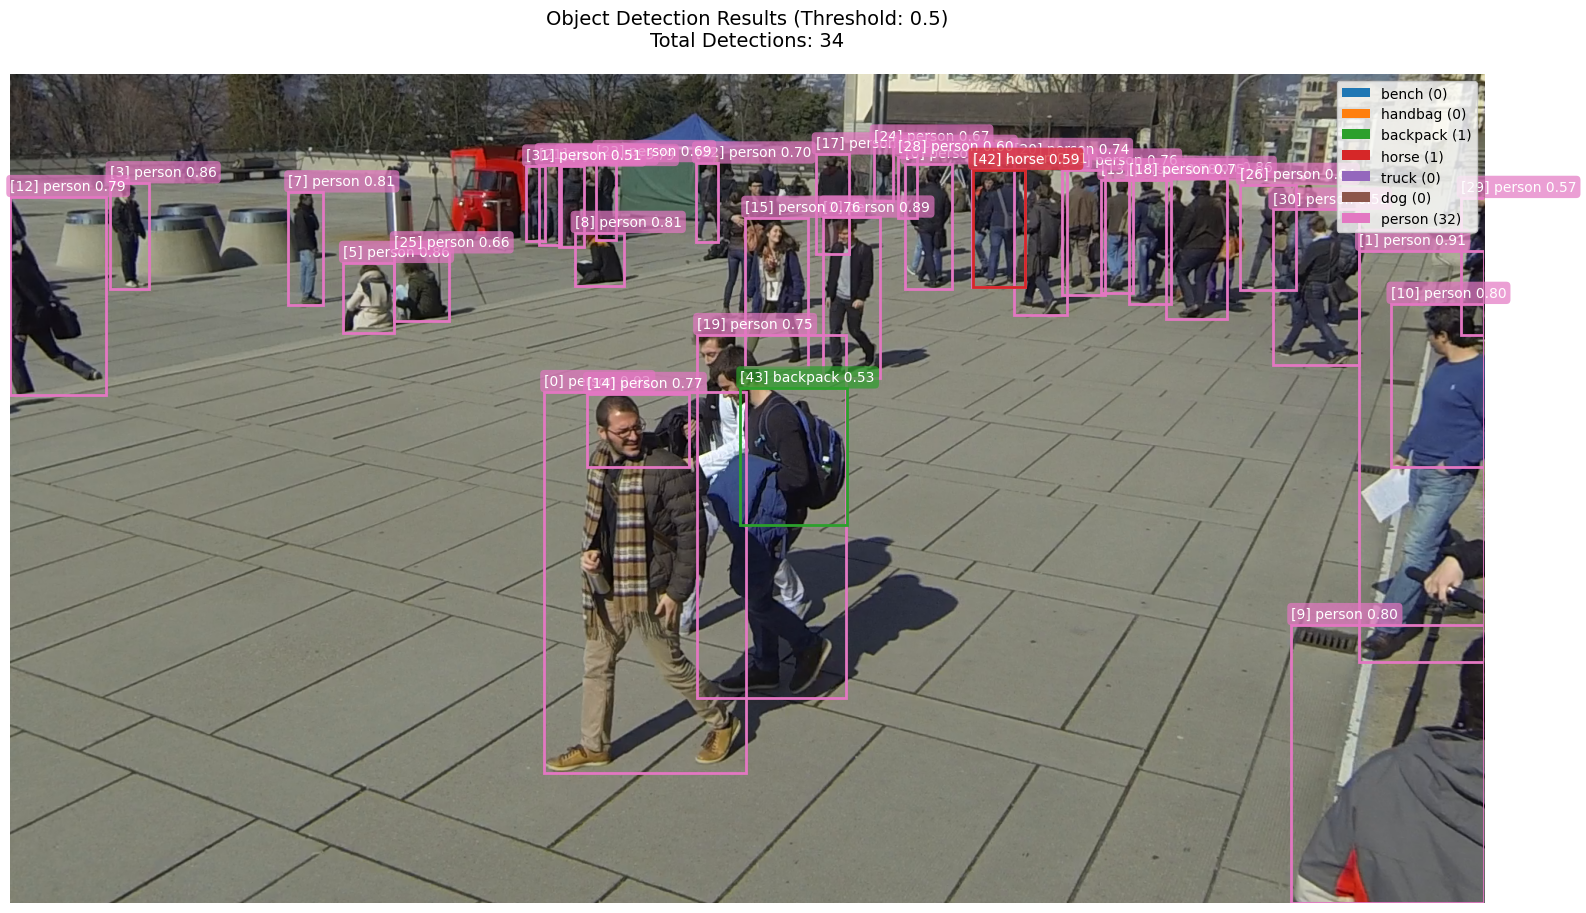


Detection Summary
Total detections: 48
Detections above threshold (0.5): 34

Category breakdown:
  bench: 0 (avg score: nan)
  handbag: 0 (avg score: nan)
  backpack: 1 (avg score: 0.531)
  horse: 1 (avg score: 0.593)
  truck: 0 (avg score: nan)
  dog: 0 (avg score: nan)
  person: 32 (avg score: 0.747)



/Users/eriwang/Desktop/cv-project-2025/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/Users/eriwang/Desktop/cv-project-2025/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning:

invalid value encountered in scalar divide



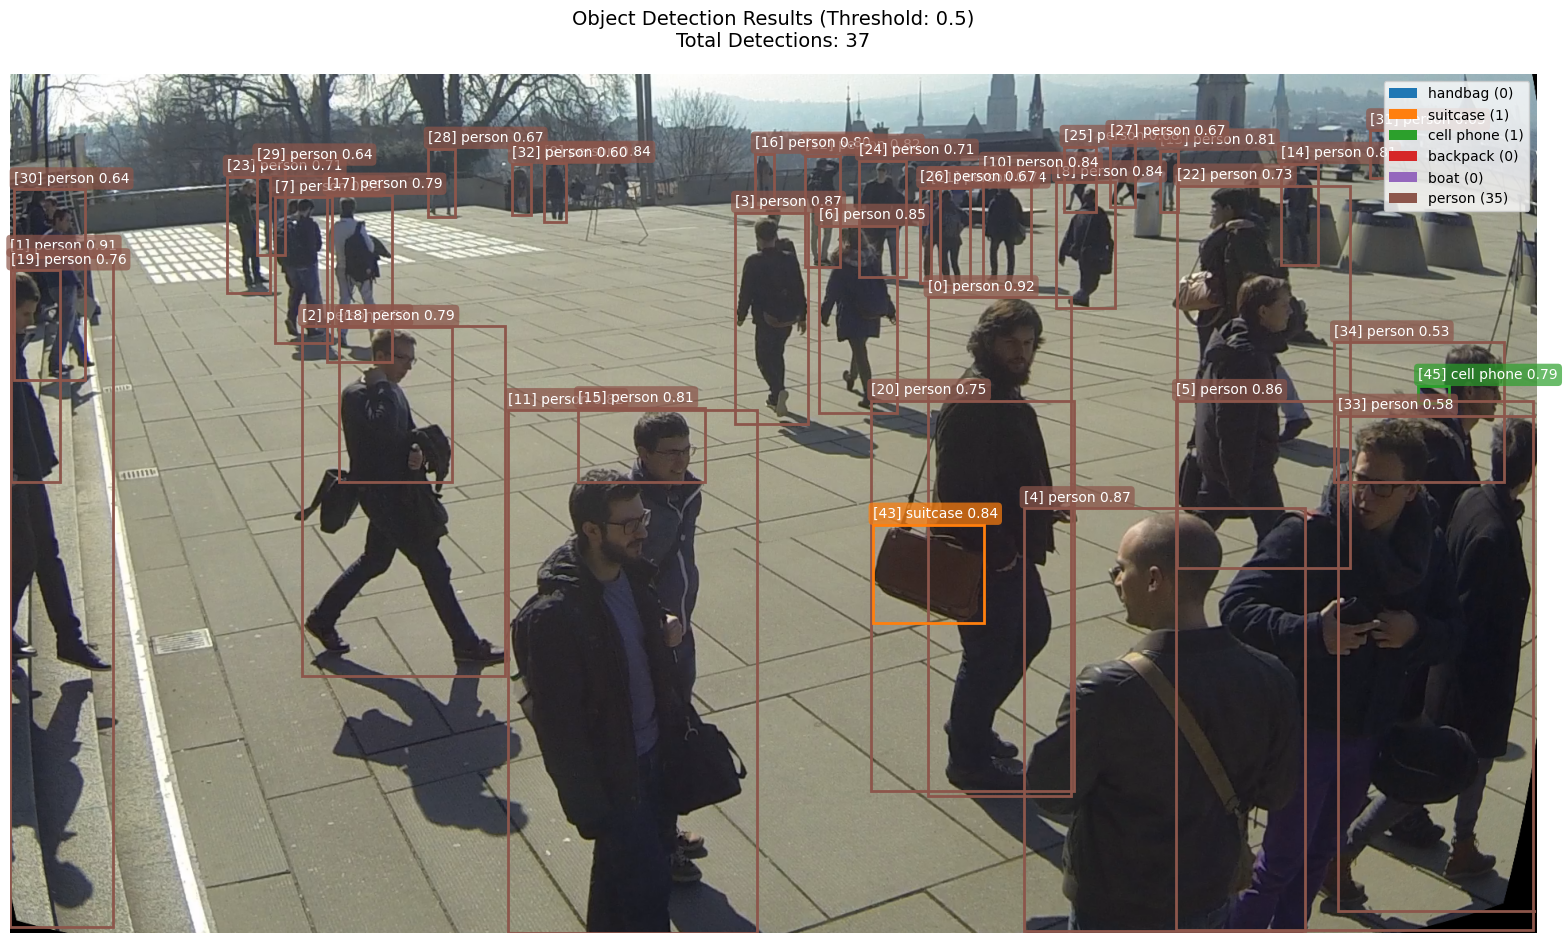


Detection Summary
Total detections: 47
Detections above threshold (0.5): 37

Category breakdown:
  handbag: 0 (avg score: nan)
  suitcase: 1 (avg score: 0.843)
  cell phone: 1 (avg score: 0.788)
  backpack: 0 (avg score: nan)
  boat: 0 (avg score: nan)
  person: 35 (avg score: 0.764)



In [15]:
cam = "C1"
visualize_predictions(
    image=image_df[cam][IMAGE_INDEX],
    bboxes=full_data[cam]['bboxes'],
    scores=full_data[cam]['scores'],
    categories=full_data[cam]['categories'],
    score_threshold=0.5
)
cam = "C3"
visualize_predictions(
    image=image_df[cam][IMAGE_INDEX],
    bboxes=full_data[cam]['bboxes'],
    scores=full_data[cam]['scores'],
    categories=full_data[cam]['categories'],
    score_threshold=0.5
)

In [16]:
# plot rays in 3D, with camera center
ray_length = 2500 # length of the rays for visualization

# bbox / slice indices you want to visualize per camera
# indices refer to slices AFTER sorting by score (same as your current logic)
slices_to_draw = {
    "C1": [0],
    "C3": [29],
}


#######
fig = go.Figure()
for name in CAMERA_NAMES:
    C = center_data[name]
    slices = ray_slice_data[name]

    add_camera_visuals(fig, C, name, extrinsics)

    for idx in slices_to_draw.get(name, []):
        if idx >= len(slices):
            continue

        s = slices[idx]

        c = f"rgb({random.randint(0,255)},\
                  {random.randint(0,255)},\
                  {random.randint(0,255)})"

        for ray in s:
            ray_end = C + ray * ray_length
            fig.add_trace(
                go.Scatter3d(
                    x=[C[0], ray_end[0]],
                    y=[C[1], ray_end[1]],
                    z=[C[2], ray_end[2]],
                    mode='lines',
                    line=dict(color=c, width=2),
                    showlegend=False
                )
            )
        

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    title='3D Camera Rays Visualization'
)
fig.show()
    

In [17]:
# ## Variables
# category_to_track = 'person'

# xrange = (-500, 1500)
# yrange = (-1200, 2500)
# zrange = (-0, 400)
# spacing = 100

# ############################
# def point_in_wedge(point, origin, rays):
#     """
#     Check if a point is in the wedge formed by rays. Accepts CCW or CW ray orientation.
#     """
#     v = point - origin
#     v = v / np.linalg.norm(v)
    
#     # Compute centroid of the 4 rays (approximate center of wedge)
#     centroid = np.mean(rays, axis=0)
#     centroid = centroid / np.linalg.norm(centroid)
    
#     score = 0
#     for i in range(rays.shape[0]):
#         ray1 = rays[i]
#         ray2 = rays[(i+1) % 4]
        
#         normal = np.cross(ray1, ray2)
        
#         # Determine if normal should point inward or outward
#         # by checking which side the centroid is on
#         if np.dot(centroid, normal) > 0:
#             # Centroid is on positive side, so that's "inside"
#             if np.dot(v, normal) < 0:
#                 return False, 0.0

#         else:
#             # Centroid is on negative side
#             if np.dot(v, normal) > 0:
#                 return False, 0.0
        
#         score += np.abs(np.dot(v, normal)) # score based on how close to ray the point is --> should be max. at the center.
    
#     return True, score

# def ndindex_range(ranges, step):
#     return itertools.product(*(range(start, end, step) for start, end in ranges))

# voxel_points = list(ndindex_range((xrange, yrange, zrange), spacing))
# # format: Dictionary with categories, each with 3d point keys, each with a dictionary of cameras as keys, each with a dictionary of ("bbox_idx", "bbox_weight") as keys
# voxel_dict = dict(zip(
#     voxel_points, 
#     [ 
#         deepcopy(dict(zip( CAMERA_NAMES, [
#             deepcopy({
#                 "slice_idx": [],
#                 "slice_weight": [],
#             }) for _ in CAMERA_NAMES
#         ] ))) for _ in voxel_points 
#     ]
# ))

# points_to_remove = []
# for point in tqdm(voxel_points):
#     in_any_slice = False # lets you remove points with nothing going on
#     for cam in CAMERA_NAMES:
#         point_info = voxel_dict[point][cam]

#         ray_slices = ray_slice_data[cam]
#         slice_areas = ray_slice_area_data[cam]
#         categories = category_data[cam]
#         slice_scores = score_data[cam]
        
#         for slice_idx, (rays, area, score, cat) in enumerate(zip(ray_slices, slice_areas, slice_scores, categories)):
#             if cat.lower() != category_to_track.lower(): # category filtering
#                 continue

#             in_wedge, alignment_score = point_in_wedge(
#                 point=point,
#                 origin=C,
#                 rays=rays
#             )

#             if in_wedge:
#                 in_any_slice = True

#                 point_info['slice_idx'].append(slice_idx)
                
#                 distance_squared = np.sum(np.square(C + point))
#                 point_info['slice_weight'].append(   # basically confidence score
#                     alignment_score * score / (area * distance_squared)
#                 )

#     # remove points with nothing going on
#     if not in_any_slice:
#         points_to_remove.append(point)